# Import Lib & Data


In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

In [5]:
df_mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")
df_cts = pd.read_csv("../Acar_data/concentrations.txt", delim_whitespace=True)

/var/folders/55/brtsb88x4wz9n5kxdtldl3940000gn/T/ipykernel_93830/381926838.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_cts = pd.read_csv("../Acar_data/concentrations.txt", delim_whitespace=True)


In [6]:
df_cts.head(3)

,Val-Tyr-Val,Trp-Gly,Phe,Malto,Propanol
1,5.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,0.0


In [7]:
print(df_mat.keys())
print(df_mat["X"].dtype.names)

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'X', 'Z'])
('name', 'type', 'author', 'date', 'moddate', 'imagesize', 'imagemode', 'data', 'label', 'axisscale', 'imageaxisscale', 'title', 'class', 'include', 'classlookup', 'axistype', 'imageaxistype', 'description', 'userdata', 'datasetversion', 'history', 'uniqueid')


In [8]:
data_dic = {}
dimensions = ["X", "Y", "Z"]
for dim in dimensions:
    mesurement_technique = df_mat[dim]["name"][0][0][0]
    data = df_mat[dim]["data"][0][0]
    data_dic[mesurement_technique] = data
    print(f"Extracted {mesurement_technique} data with shape {data.shape}")

X_eem = data_dic["EEM"]
X_nmr = data_dic["3-way NMR"]
X_lcms = data_dic["LCMS"]

Extracted EEM data with shape (28, 251, 21)
Extracted 3-way NMR data with shape (28, 13324, 8)
Extracted LCMS data with shape (28, 168)


# Check for missing values


In [9]:
print("NaNs ?", np.isnan(X_lcms).any())
print("Inf ?", np.isinf(X_lcms).any())
nb_of_values = X_lcms.shape[0] * X_lcms.shape[1]
nb_nan = np.isnan(X_lcms).sum()
print(f"NaN ratio : {nb_nan} / {nb_of_values} = {nb_nan/nb_of_values:.2%}")

NaNs ? False
Inf ? False
NaN ratio : 0 / 4704 = 0.00%


In [10]:
print("NaNs ?", np.isnan(X_nmr).any())
print("Inf ?", np.isinf(X_nmr).any())
nb_of_values = X_nmr.shape[0] * X_nmr.shape[1] * X_nmr.shape[2]
nb_nan = np.isnan(X_nmr).sum()
print(f"NaN ratio : {nb_nan} / {nb_of_values} = {nb_nan/nb_of_values:.2%}")

NaNs ? False
Inf ? False
NaN ratio : 0 / 2984576 = 0.00%


In [11]:
print("NaNs ?", np.isnan(X_eem).any())
print("Inf ?", np.isinf(X_eem).any())
nb_of_values = X_eem.shape[0] * X_eem.shape[1] * X_eem.shape[2]
nb_nan = np.isnan(X_eem).sum()
print(f"NaN ratio : {nb_nan} / {nb_of_values} = {nb_nan/nb_of_values:.2%}")

NaNs ? True
Inf ? False
NaN ratio : 11508 / 147588 = 7.80%


In [12]:
mask = np.isnan(X_eem)
idxs = np.where(mask)
print(f"Along dimension 0: {idxs[0]}")
print(f"Along dimension 1: {idxs[1]}")
print(f"Along dimension 2: {idxs[2]}")

Along dimension 0: [ 0  0  0 ... 27 27 27]
Along dimension 1: [  0   0   0 ... 249 250 250]
Along dimension 2: [7 8 9 ... 9 8 9]


Each of the 28 samples has data that is a 2D array of shape (251,21) and it has missing values among these 21 features.
Hence, for each sample, we will impute the missing values using the mean across the 251 rows from the slice.


<Axes: >

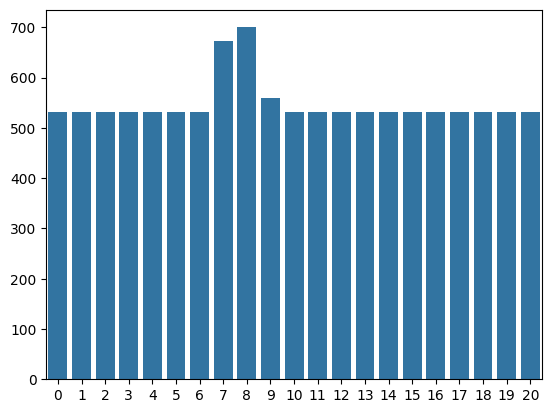

In [13]:
# count the number of occurence of each index in indxs[2]
unique, counts = np.unique(idxs[2], return_counts=True)
sns.barplot(x=unique, y=counts)

In [14]:
X_eem.shape[0] * X_eem.shape[1]

7028

There are around 550 missing values for each index of the last dimension and there are `X_eem.shape[0]*X_eem.shape[1]=7028` samples in total. This is enough to do imputation.


# Impute missing values for EEM


In [15]:
# Impute the array, we will use the mean across the 2nd axis

X_eem_imputed = X_eem.copy()
means = np.nanmean(X_eem, axis=1)
for i in range(X_eem.shape[0]):
    X_eem_imputed[i, :, :] = np.where(
        np.isnan(X_eem[i, :, :]), means[i], X_eem[i, :, :]
    )

In [16]:
print("NaNs ?", np.isnan(X_eem_imputed).any())
print("Inf ?", np.isinf(X_eem_imputed).any())
nb_of_values = X_eem_imputed.shape[0] * X_eem_imputed.shape[1] * X_eem_imputed.shape[2]
nb_nan = np.isnan(X_eem_imputed).sum()
print(f"NaN ratio : {nb_nan} / {nb_of_values} = {nb_nan/nb_of_values:.2%}")

NaNs ? False
Inf ? False
NaN ratio : 0 / 147588 = 0.00%
